In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

In [61]:
expectation_path = ".../2025-04-17_Home Price Inflation Expectation v Reality"

zillow_home_price_path = '.../2025-04-17_Home Price Inflation Expectation v Reality/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv'

home_price_ex = pd.read_excel(os.path.join(expectation_path,'FRBNY-SCE-Data (1).xlsx'),sheet_name = 'Home price expectations')
home_price_in = pd.read_csv(zillow_home_price_path)

In [3]:
path = '.../2025-04-17_Home Price Inflation Expectation v Reality'

## home Price Inflation

In [4]:
home_price_in_US = home_price_in[home_price_in['RegionName'] == 'United States']

home_price_in_US_tr = home_price_in_US.melt(id_vars = 'RegionName',var_name='Home Price')

In [5]:
home_price_in_US_tr = home_price_in_US_tr[4:].reset_index(drop=True)

In [6]:
home_price_in_US_tr['infl'] = home_price_in_US_tr['value'].pct_change(12)*100
home_price_in_US_tr['infl_36'] = home_price_in_US_tr['value'].pct_change(36)*100

In [7]:
home_price_in_US_tr.dropna(inplace = True)

In [8]:
home_price_in_US_tr.rename(columns = {'Home Price':'Months'},inplace = True)

In [9]:
home_price_in_US_tr['Months'] = pd.to_datetime(home_price_in_US_tr['Months'], format='%Y-%m-%d')

In [10]:
home_price_in_US_tr['Months'] = pd.to_datetime(home_price_in_US_tr['Months'])
home_price_in_US_tr['Months'] = home_price_in_US_tr['Months'].dt.to_period('M').dt.to_timestamp()


In [11]:
home_price_in_US_tr['lag_infl_12']= home_price_in_US_tr['infl'].shift(12)
home_price_in_US_tr['lag_infl_36']= home_price_in_US_tr['infl'].shift(36)

In [12]:
home_price_in_US_tr

,RegionName,Months,value,infl,infl_36,lag_infl_12,lag_infl_36
36,United States,2003-01-01,148944.225233,7.263325,22.419059,NaN,NaN
37,United States,2003-02-01,149734.309556,7.348212,22.852302,NaN,NaN
38,United States,2003-03-01,150523.966093,7.422695,23.231794,NaN,NaN
39,United States,2003-04-01,151383.650703,7.503366,23.360597,NaN,NaN
40,United States,2003-05-01,152329.524296,7.588960,23.472087,NaN,NaN
...,...,...,...,...,...,...,...
298,United States,2024-11-01,359735.50407,2.547742,16.745147,2.240924,16.311235
299,United States,2024-12-01,360452.36765,2.625490,15.768235,2.639846,15.876968
300,United States,2025-01-01,361079.287696,2.678085,14.342996,3.125847,15.960088
301,United States,2025-02-01,361536.63236,2.577929,12.596330,3.622689,16.324382


## Home Price Expectations

In [13]:
home_price_ex.columns = home_price_ex.iloc[2]


In [14]:
home_price_ex.rename(columns={home_price_ex.columns[0]: 'Months'}, inplace=True)


In [15]:
home_price_ex.dropna(inplace = True)

In [16]:
home_price_ex_red = home_price_ex[['Months','Median one-year ahead point prediction',
                                   'Median three-year ahead point prediction']]

In [17]:
home_price_ex_red['Months'] = pd.to_datetime(home_price_ex_red['Months'], format='%Y%m')


In [18]:
home_price_ex_red

2,Months,Median one-year ahead point prediction,Median three-year ahead point prediction
3,2013-06-01,5.55256,5.479406
4,2013-07-01,5.43434,5.527019
5,2013-08-01,5.680693,5.498374
6,2013-09-01,5.376008,5.538333
7,2013-10-01,5.298479,5.382698
...,...,...,...
140,2024-11-01,4.639712,4.617858
141,2024-12-01,4.655005,4.559384
142,2025-01-01,4.696658,4.554412
143,2025-02-01,5.131184,4.890265


## Merging of datasets

In [19]:
# keep one clean copy of the expectation columns when you merge
merged_df = pd.merge(
    home_price_in_US_tr,
    home_price_ex_red[['Months',
                       'Median one-year ahead point prediction',
                       'Median three-year ahead point prediction']],
    on='Months',
    how='outer'
)

# --- remainder identical to what you had ---

merged_df['Months'] = pd.to_datetime(merged_df['Months'])
merged_df = merged_df.sort_values('Months')

last = merged_df['Months'].iloc[-1]
future = pd.date_range(last + pd.offsets.MonthBegin(),
                       periods=36,
                       freq='MS')

merged_df = (
    pd.concat([merged_df, pd.DataFrame({'Months': future})], ignore_index=True)
      .sort_values('Months')
      .reset_index(drop=True)
)

merged_df['expectation_12'] = merged_df['Median one-year ahead point prediction'].shift(12)
merged_df['expectation_36'] = merged_df['Median three-year ahead point prediction'].shift(36)

merged_df = merged_df[merged_df['Months'] > '2013-05-01']


In [20]:
merged_df[merged_df['Months'] > '2014-05-01']

,RegionName,Months,value,infl,infl_36,lag_infl_12,lag_infl_36,Median one-year ahead point prediction,Median three-year ahead point prediction,expectation_12,expectation_36
137,United States,2014-06-01,181536.031267,7.089588,12.614576,6.379726,-6.023028,5.064034,4.938948,5.55256,NaN
138,United States,2014-07-01,182401.939951,6.813824,13.654252,6.779288,-6.145359,4.962916,4.895496,5.43434,NaN
139,United States,2014-08-01,183064.931735,6.443613,14.494600,7.210935,-6.060689,4.792417,4.743077,5.680693,NaN
140,United States,2014-09-01,183686.261659,6.119437,15.253645,7.527473,-5.819621,4.915968,4.635481,5.376008,NaN
141,United States,2014-10-01,184095.975902,5.604517,15.878287,7.886540,-5.552169,4.751813,4.844677,5.298479,NaN
...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,2027-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.617858
299,NaN,2027-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.559384
300,NaN,2028-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.554412
301,NaN,2028-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.890265


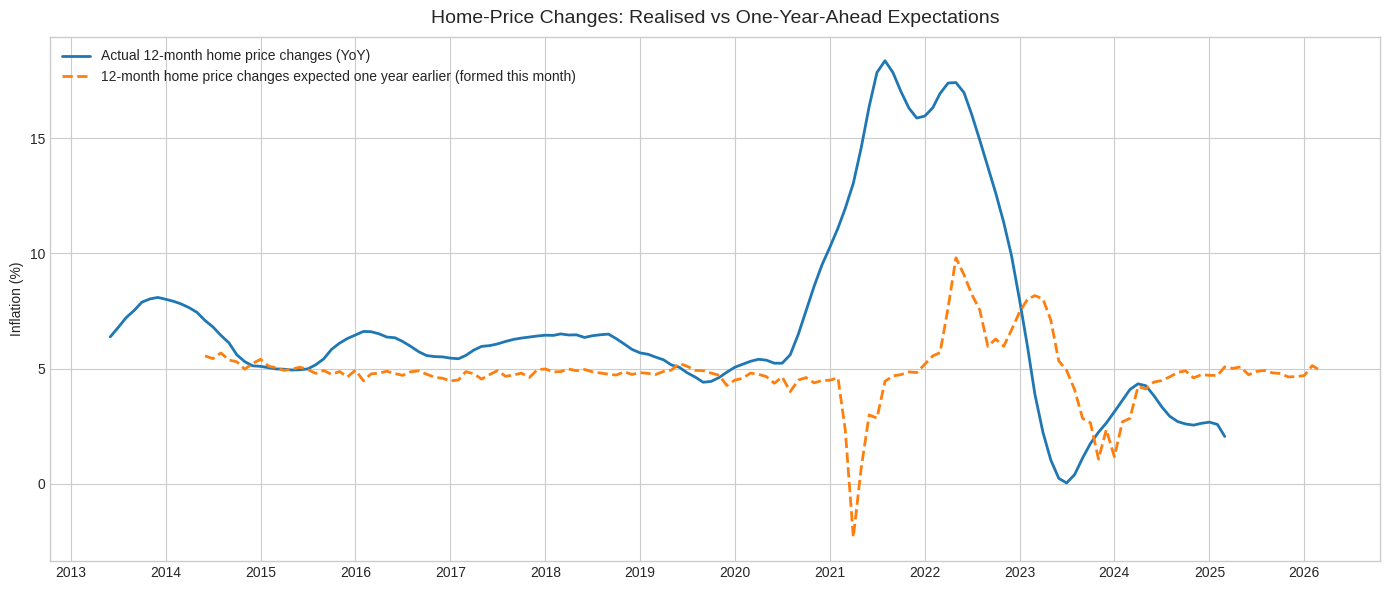

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(merged_df['Months'],
        merged_df['infl'],
        label='Actual 12‑month home price changes (YoY)',
        lw=2)

ax.plot(merged_df['Months'],
        merged_df['expectation_12'],
        label='12‑month home price changes expected one year earlier (formed this month)',
        lw=2, ls='--')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_title('Home‑Price Changes: Realised vs One‑Year‑Ahead Expectations', fontsize=14, pad=10)
ax.set_ylabel('Inflation (%)')

ax.legend(frameon=False)
fig.tight_layout()
plt.savefig(os.path.join(path,'One Year Expectations.png'))
plt.savefig(os.path.join(path,'One Year Expectations.svg'))
plt.show()


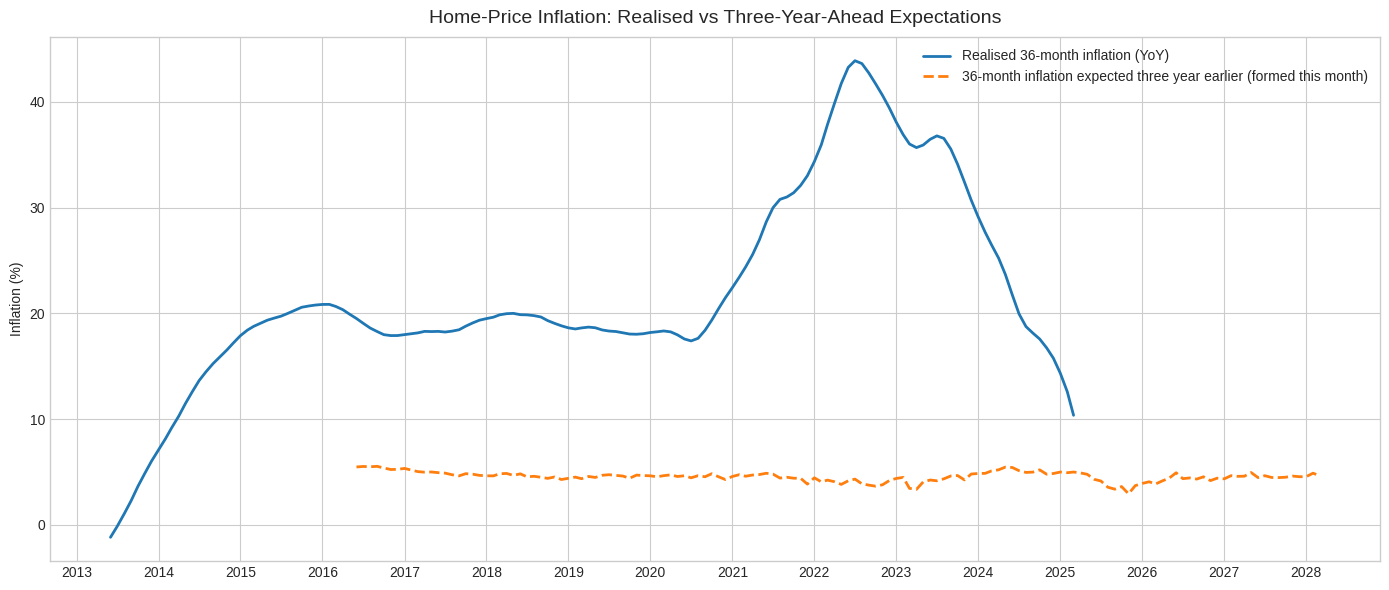

In [22]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(merged_df['Months'],
        merged_df['infl_36'],
        label='Realised 36‑month inflation (YoY)',
        lw=2)

ax.plot(merged_df['Months'],
        merged_df['expectation_36'],
        label='36-month inflation expected three year earlier (formed this month)',
        lw=2, ls='--')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_title('Home‑Price Inflation: Realised vs Three‑Year‑Ahead Expectations', fontsize=14, pad=10)
ax.set_ylabel('Inflation (%)')

ax.legend(frameon=False)
fig.tight_layout()
plt.savefig(os.path.join(path,'Three Year Expectations.png'))
plt.savefig(os.path.join(path,'Three Year Expectations.svg'))
plt.show()


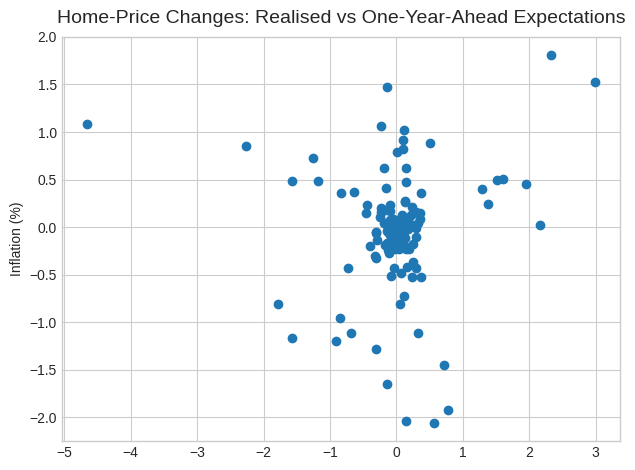

In [23]:
# plt.style.use('seaborn-v0_8-whitegrid')

# fig, ax = plt.subplots(figsize=(14, 6))

plt.scatter(merged_df['expectation_12'].diff(1),merged_df['infl'].diff(1))

plt.title('Home‑Price Changes: Realised vs One‑Year‑Ahead Expectations', fontsize=14, pad=10)
plt.ylabel('Inflation (%)')

plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig(os.path.join(path,'One Year Expectations.png'))
# plt.savefig(os.path.join(path,'One Year Expectations.svg'))
plt.show()


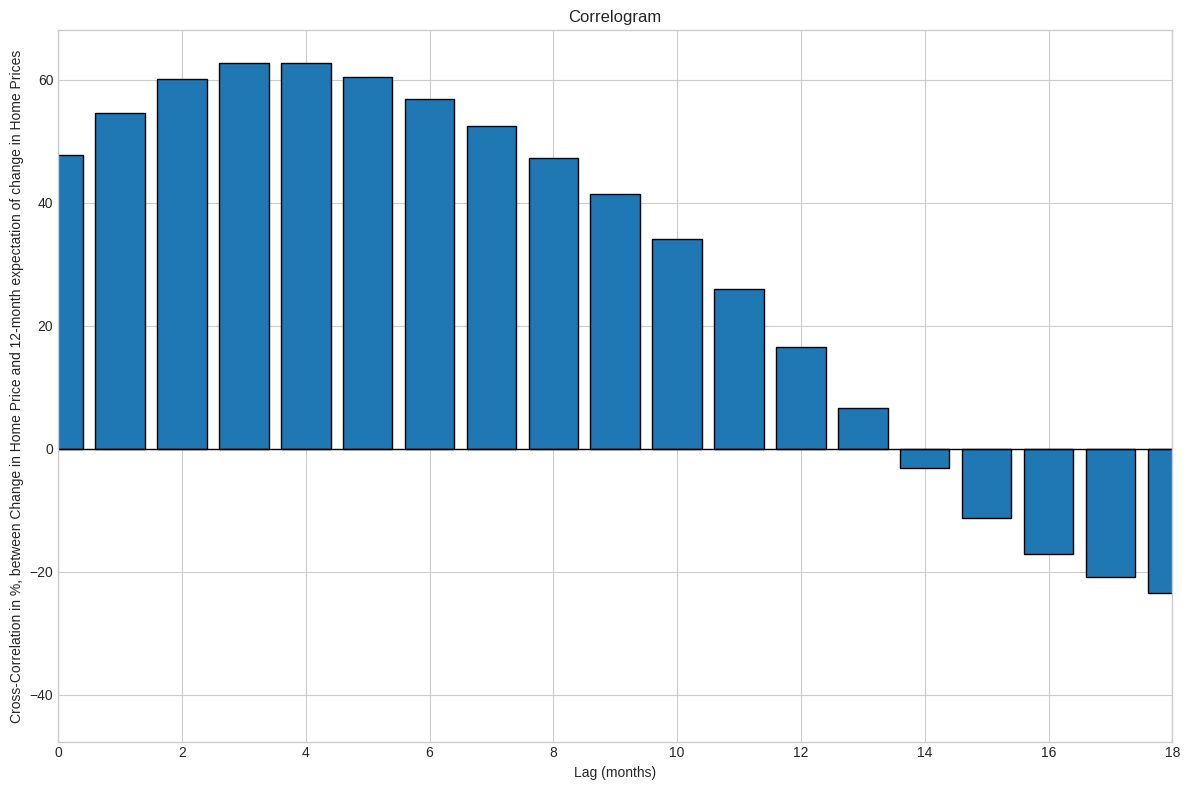

In [53]:
# drop NaNs and align the two series
pair = merged_df[['Median one-year ahead point prediction', 'infl']].dropna()
y = pair['Median one-year ahead point prediction'] - pair['Median one-year ahead point prediction'].mean()
x = pair['infl']           - pair['infl'].mean()

# choose the number of lags you care about
max_lag = 24                      # months
lags = np.arange(-max_lag, max_lag + 1)

# positive lags: x (infl) leads y; negative lags: x lags y
cc_pos = ccf(x, y, adjusted=False)[:max_lag + 1]*100      # 0 … +max_lag
cc_neg = ccf(y, x, adjusted=False)[1:max_lag + 1]*100        # −1 … −max_lag
cc  = np.concatenate((cc_neg[::-1], cc_pos))

# bar plot
plt.figure(figsize=(12, 8))
plt.bar(lags, cc, width=0.8, edgecolor='k')
plt.axhline(0, color='black', lw=1)
plt.title('Correlogram')
plt.xlabel('Lag (months)')
# Use fontsize within fontdict
plt.ylabel('Cross-Correlation in %, between Change in Home Price and 12-month expectation of change in Home Prices', fontdict={'fontsize': 10})
plt.xlim(0,18)
plt.tight_layout()
plt.savefig(os.path.join(path,'Correlogram.png'))
plt.savefig(os.path.join(path,'Correlogram.svg'))
plt.show()

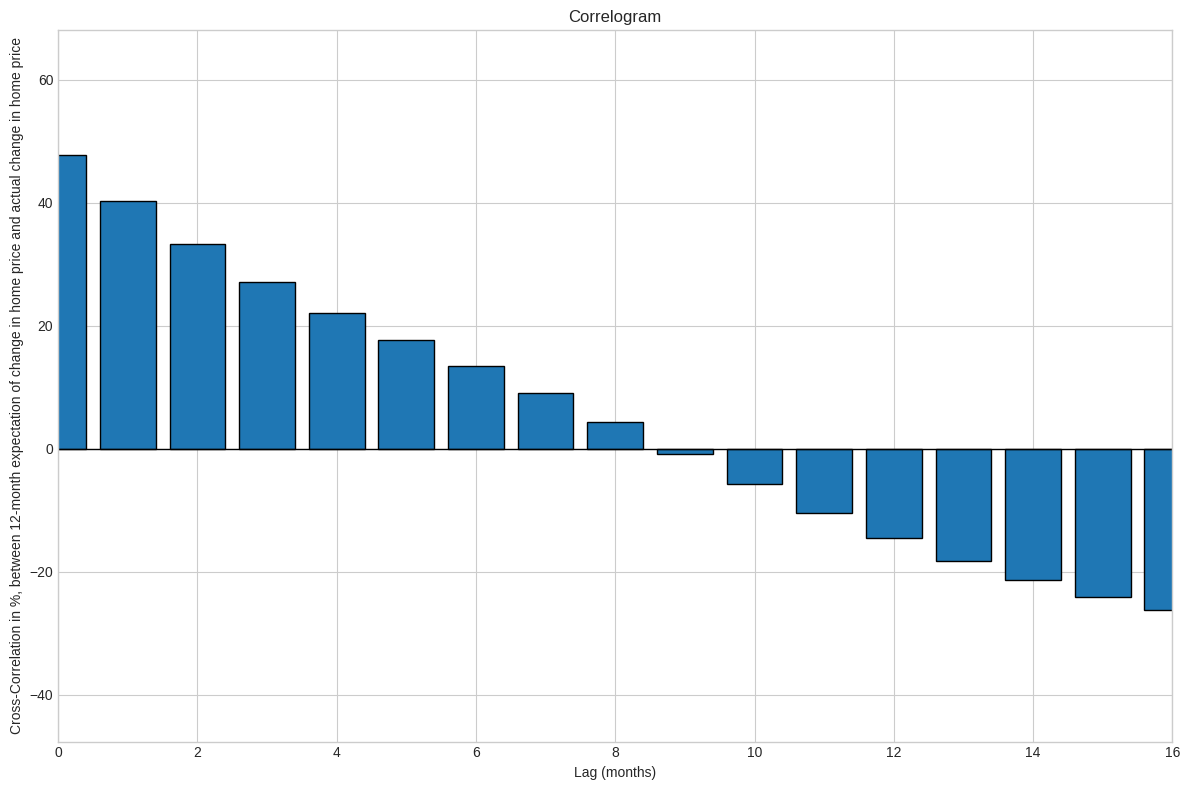

In [50]:
# drop NaNs and align the two series
pair = merged_df[['Median one-year ahead point prediction', 'infl']].dropna()
x = pair['Median one-year ahead point prediction']
y = pair['infl']

# choose the number of lags you care about
max_lag = 24                      # months
lags = np.arange(-max_lag, max_lag + 1)

# positive lags: x (infl) leads y; negative lags: x lags y
cc_pos = ccf(x, y, adjusted=False)[:max_lag + 1]*100      # 0 … +max_lag
cc_neg = ccf(y, x, adjusted=False)[1:max_lag + 1]*100        # −1 … −max_lag
cc  = np.concatenate((cc_neg[::-1], cc_pos))

# bar plot
plt.figure(figsize=(12, 8))
plt.bar(lags, cc, width=0.8, edgecolor='k')
plt.axhline(0, color='black', lw=1)
plt.title('Correlogram')
plt.xlabel('Lag (months)')
# Use fontsize within fontdict
plt.ylabel('Cross-Correlation in %, between 12-month expectation of change in home price and actual change in home price', fontdict={'fontsize': 10})
plt.xlim(0,16)
plt.tight_layout()
plt.savefig(os.path.join(path,'Correlogram_reverse.png'))
plt.savefig(os.path.join(path,'Correlogram_reverse.svg'))
plt.show()